<a href="https://colab.research.google.com/github/Kmatsu-tokudai/code/blob/master/STEM_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**STEM演習第5回** 
- Google Colaboratory によるWord2vecの体験





準備その１（ベクトルを置くディレクトリを用意）

In [ ]:
# Google Drive のマウント
from google.colab import drive
drive.mount('/content/drive')
# vectorディレクトリを作成
!mkdir -p "/content/drive/My Drive/vector"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


準備その２（学習済みベクトルデータをダウンロードしてディレクトリにコピー）

In [ ]:
# Google Driveにファイルをアップロード
# 白ヤギコーポレーションから学習済みベクトルモデルをダウンロード
!wget http://public.shiroyagi.s3.amazonaws.com/latest-ja-word2vec-gensim-model.zip
# 解凍する
!unzip latest-ja-word2vec-gensim-model.zip
# ファイルをGoogle Driveのvectorディレクトリにコピー
!cp word2vec.gensim.* "/content/drive/My Drive/vector/"

--2020-10-27 04:04:19--  http://public.shiroyagi.s3.amazonaws.com/latest-ja-word2vec-gensim-model.zip
Resolving public.shiroyagi.s3.amazonaws.com (public.shiroyagi.s3.amazonaws.com)... 52.219.16.77
Connecting to public.shiroyagi.s3.amazonaws.com (public.shiroyagi.s3.amazonaws.com)|52.219.16.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132936751 (127M) [application/zip]
Saving to: ‘latest-ja-word2vec-gensim-model.zip’

latest-ja-word2vec- 100%[===================>] 126.78M  32.6MB/s    in 4.5s    

2020-10-27 04:04:24 (28.1 MB/s) - ‘latest-ja-word2vec-gensim-model.zip’ saved [132936751/132936751]

Archive:  latest-ja-word2vec-gensim-model.zip
  inflating: word2vec.gensim.model   
  inflating: word2vec.gensim.model.syn1neg.npy  
  inflating: word2vec.gensim.model.wv.syn0.npy  


gensimライブラリを用いてWord2vecのモデルを読込み、類似語を検索してみる

In [ ]:
import os
import gensim
import warnings
from gensim.models import Word2Vec

warnings.simplefilter('ignore')

if not os.path.exists('/content/drive/My Drive/vector/word2vec.gensim.model'):
    raise ValueError("SKIP: You need to download the word2vec.gensim.model model")
    
# 学習済みWord2vecを読込
wv = Word2Vec.load("/content/drive/My Drive/vector/word2vec.gensim.model")

# 「講義」という単語と類似する語を検索
results = wv.most_similar(positive=['講義'])
for result in results:
    print(result)


('講話', 0.7878658175468445)
('授業', 0.7650410532951355)
('講演', 0.7614888548851013)
('講義ノート', 0.7420766949653625)
('聴講', 0.7418225407600403)
('作文', 0.7344423532485962)
('臨床実習', 0.7298046350479126)
('個人教授', 0.7268437147140503)
('教職', 0.720413088798523)
('教育', 0.7202420830726624)


単語の足し算・引き算をしてみる

In [ ]:
# 単語の意味の足し算・引き算

def similar_word(posi, nega=[], n=10):
    count = 1
    result = wv.most_similar(positive = posi, negative = nega, topn = n)
    for r in result:
        print(str(count)+" "+str(r[0])+" "+str(r[1]))
        count += 1

# 足し算引き算を行う
def calc_addition_subtraction(equation):
    if "+" not in equation or "-" not in equation:
        similar_word([equation])
    else:
        posi,nega = [],[]
        positives = equation.split("+")
        for positive in positives:
            negatives = positive.split("-")
            posi.append(negatives[0])
            nega = nega + negatives[1:]
        similar_word(posi = posi, nega = nega)


if __name__=="__main__":
    equation = 'マリオ+ポケモン-ピカチュウ'
    calc_addition_subtraction(equation)

1 ジムリーダー 0.7786595821380615
2 ヨッシー 0.7650797367095947
3 クッパ 0.7615779638290405
4 モンスター 0.7608561515808105
5 ジョウト地方 0.7531558871269226
6 ルイージ 0.7522788643836975
7 プレイヤー 0.744318962097168
8 プレイヤーキャラクター 0.7404342293739319
9 キャラクター 0.7320311665534973
10 魔法使い 0.7198766469955444


形態素解析器MeCabライブラリのインストール

In [ ]:
# MeCabライブラリのインストール
!apt-get -q -y install sudo file mecab libmecab-dev mecab-ipadic-utf8 git curl python-mecab > /dev/null
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git > /dev/null 
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n > /dev/null 2>&1
!pip install mecab-python3 > /dev/null

# シンボリックリンクによるエラー回避
!ln -s /etc/mecabrc /usr/local/etc/mecabrc

!echo `mecab-config --dicdir`"/mecab-ipadic-neologd"

Cloning into 'mecab-ipadic-neologd'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 75 (delta 5), reused 54 (delta 0), pack-reused 0
Unpacking objects: 100% (75/75), done.
/usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd


文の形態素解析を行い、文間の距離を計算してみる

In [ ]:
# gensimのword mover's distance(wmdistance) モジュールをテスト

s1 = '私は学校に行きたいです。'
s2 = '彼は大学に登校したいです。'
s3 = '私は学校に行きたくないです。'
import MeCab

mec = MeCab.Tagger()
# 形態素解析器による単語への分割
# wlistは単語が登録されたリスト
def wakati(sen):
    node = mec.parseToNode(sen)
    wlist = []
    while node:
        wlist.append(node.surface)
        node = node.next
    return wlist

w1 = wakati(s1)
w2 = wakati(s2)
w3 = wakati(s3)
#print(w1, w2)
wmdistance = wv.wmdistance(s1, s2)
print('WMD dist({},{})={:.3f}'.format(s1, s2, wmdistance))

wmdistance = wv.wmdistance(s1, s3)
print('WMD dist({},{})={:.3f}'.format(s1, s3, wmdistance))



WMD dist(私は学校に行きたいです。,彼は大学に登校したいです。)=0.378
WMD dist(私は学校に行きたいです。,私は学校に行きたくないです。)=0.189


類似語のワードクラウドを作成

1.5.0


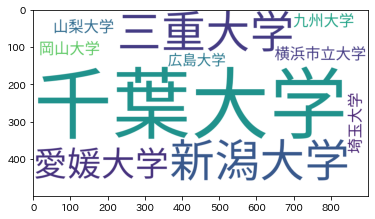

<Figure size 432x288 with 0 Axes>

In [ ]:
#!pip install japanize-matplotlib
import matplotlib.pyplot as plt
import japanize_matplotlib
# 日本語フォントをダウンロードする。
!wget https://noto-website-2.storage.googleapis.com/pkgs/Noto-unhinted.zip
!unzip Noto-unhinted.zip

!mkdir -p /content/fonts
!mv *otf /content/fonts
!fc-cache -f -v

import wordcloud
print(wordcloud.__version__)
from wordcloud import WordCloud

# 「徳島大学」という単語と類似する語を検索
results = wv.most_similar(positive=['徳島大学'])
simstr = ''
for result in results:
    simstr += '{} '.format(result[0])
simstr = simstr.rstrip(' ')
wordcloud = WordCloud(background_color="white",
                      font_path="fonts/NotoSansCJKjp-Regular.otf",
                      width=900, height=500).generate(simstr)

wordcloud.generate(simstr)
plt.imshow(wordcloud)
plt.show()
plt.savefig("./similar_wordcloud.png")
